In [1]:
import torchvision
import torch
import numpy
import torch.nn as nn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset=MNIST(root="C:",download=True,transform=ToTensor())

torch.Size([1, 28, 28]) 3


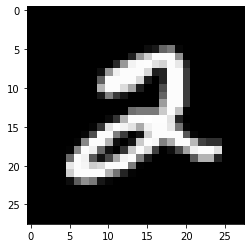

In [3]:
image,lable=dataset[5]
print(image.shape,image.ndim)
plt.imshow(torch.permute(image,(1,2,0)),cmap="gray")

In [4]:
train_ds,val_ds=random_split(dataset,[50000,10000])
train_loader=DataLoader(train_ds,128,shuffle=True)
val_loader=DataLoader(val_ds,128)

torch.Size([128, 1, 28, 28])
torch.Size([242, 482, 3])


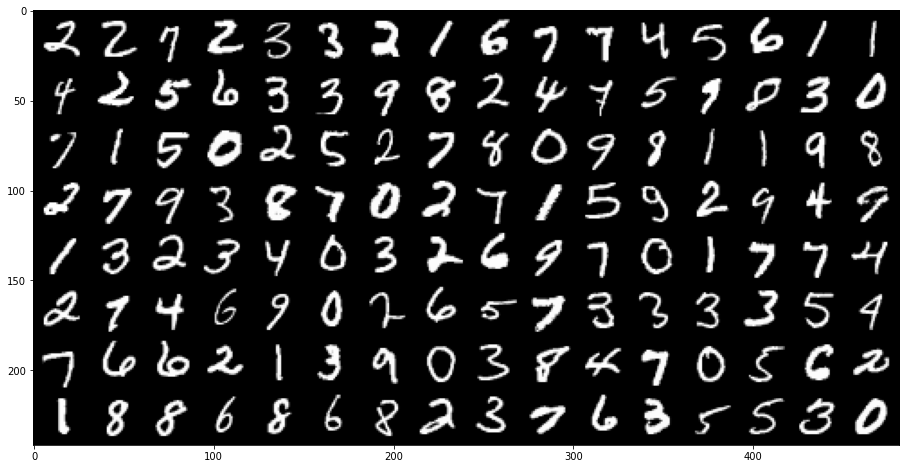

In [5]:
for img,_ in train_loader:
    print(img.shape)
    plt.figure(figsize=(16,8))
    print(make_grid(img,nrow=16).permute(1,2,0).shape)
    plt.imshow(make_grid(img,nrow=16).permute(1,2,0))
    break

In [6]:
def accuracy(out,lab):
    _,preds=torch.max(out,dim=1)
    return torch.tensor(torch.sum(preds==lab).item()/len(preds))

In [7]:
def evaluate(model,val_loader):
    e=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(e)

In [8]:
def fit(epochs,model,lr,train_loader,val_loader,opt_func=torch.optim.SGD):
    optimizer=opt_func(model.parameters(),lr)
    history=[]

    for epoch in range(epochs):
        for batch in train_loader:
            loss=model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        res=evaluate(model,val_loader)
        model.epoch_end(epoch,res)
        history.append(res)
    return history

In [9]:
class amodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(784,64)
        self.layer2=nn.Linear(64,10)
    def forward(self,x):
        x=x.view(x.size(0),-1)
        out=self.layer1(x)
        out=f.relu(out)
        out=self.layer2(out)
        return out
    
    def training_step(self,batch):
        images,lables=batch
        out=self.forward(images)
        loss=f.cross_entropy(out,lables)
        return loss
    
    def validation_step(self,batch):
        images, lables =batch
        out=self.forward(images)
        loss=f.cross_entropy(out,lables)
        acc=accuracy(out,lables)
        return {"val_loss":loss,"val_acc":acc}
    
    def validation_epoch_end(self,out):
        batch_loss=[x["val_loss"] for x in out]
        batch_acc=[x["val_acc"] for x in out]
        epoch_loss=torch.stack(batch_loss).mean()
        epoch_acc=torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(),"val_acc":epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch[{}] ,val_loss:{:.4f},val_acc:{:.4f} ".format(epoch,result["val_loss"],result["val_acc"]))
model=amodel()

In [10]:
history1=fit(6,model,0.4,train_loader,val_loader)

Epoch[0] ,val_loss:0.2327,val_acc:0.9301 
Epoch[1] ,val_loss:0.1648,val_acc:0.9516 
Epoch[2] ,val_loss:0.1443,val_acc:0.9569 
Epoch[3] ,val_loss:0.1320,val_acc:0.9602 
Epoch[4] ,val_loss:0.1072,val_acc:0.9686 
Epoch[5] ,val_loss:0.1013,val_acc:0.9692 


In [11]:
history2=fit(6,model,0.1,train_loader,val_loader)

Epoch[0] ,val_loss:0.0926,val_acc:0.9719 
Epoch[1] ,val_loss:0.0921,val_acc:0.9718 
Epoch[2] ,val_loss:0.0900,val_acc:0.9731 
Epoch[3] ,val_loss:0.0901,val_acc:0.9729 
Epoch[4] ,val_loss:0.0887,val_acc:0.9732 
Epoch[5] ,val_loss:0.0891,val_acc:0.9728 


In [12]:
torch.save(model.state_dict(),"Working with MNIST(Non Linear relations).pth")

In [13]:
model2=amodel()
model2.load_state_dict(torch.load("Working with MNIST(Non Linear relations).pth"))
model2.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.0051, -0.0065,  0.0221,  ..., -0.0228,  0.0266, -0.0137],
                      [ 0.0090,  0.0193, -0.0346,  ...,  0.0284,  0.0296,  0.0269],
                      [ 0.0347, -0.0288,  0.0166,  ...,  0.0252, -0.0071, -0.0247],
                      ...,
                      [-0.0197,  0.0186, -0.0212,  ...,  0.0331,  0.0257,  0.0353],
                      [-0.0143, -0.0076, -0.0015,  ..., -0.0346,  0.0243, -0.0250],
                      [-0.0062,  0.0118,  0.0031,  ...,  0.0029, -0.0016,  0.0142]])),
             ('layer1.bias',
              tensor([ 0.0109,  0.1765,  0.1109,  0.0776, -0.0021,  0.0295,  0.0825,  0.1496,
                      -0.0012,  0.0443, -0.0671,  0.2618, -0.0037,  0.2659, -0.0008, -0.1161,
                       0.1961,  0.1505, -0.0428, -0.0395,  0.0935, -0.0608,  0.1462, -0.0196,
                      -0.0614,  0.3553,  0.1603,  0.0815,  0.0342, -0.0057, -0.0375,  0.0270,
                      -0.0447,